# 14_SABR_demo.ipynb

This notebook demonstrates the **lognormal SABR (Hagan 2002)** workflow added to the library:

- Hagan asymptotic **implied volatility** `sabr_iv(F,K,T,alpha,beta,rho,nu)`
- Pricing via **SABR → BS** mapping `sabr_price(S,K,T,r,q,...)`
- **Sanity checks** (limits, monotonicity, ATM continuity)
- **Smile generation** and visualization
- **Calibration in IV-space** (optionally fixing β) and **price-space** (with vega weights)
- Quick **robustness** checks and diagnostics

> Tip: For real-market calibration, see the optional section at the end (uses your `data_loader`).


In [1]:
# Imports & plotting
import os, sys, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)


from src.sabr import sabr_iv, sabr_price, sabr_calibrate_iv, sabr_calibrate_price
from src.black_scholes import black_scholes_price, bs_call_forward, bs_put_forward, implied_vol_from_price

np.set_printoptions(precision=6, suppress=True)
plt.rcParams["figure.figsize"] = (7.5, 4.5)


## 1) Quick sanity checks
We verify two properties:

1. **BS limit**: with `beta=1` and `nu=0`, SABR reduces to BS with σ = α (for all K).
2. **ATM continuity**: `sabr_iv` is continuous as K → F.


In [2]:
# 1. BS limit: beta=1, nu=0 => SABR == BS with sigma=alpha
S, r, q = 100.0, 0.01, 0.00
T = 1.0
alpha, beta, rho, nu = 0.2, 1.0, -0.5, 0.0   # rho irrelevant when nu=0

Ks = np.array([60, 80, 90, 100, 110, 140], float)
c_sabr = [sabr_price(S, K, T, r, q, alpha, beta, rho, nu, option="call") for K in Ks]
c_bs   = [black_scholes_price(S, K, T, r, alpha, option_type="call")      for K in Ks]
print("max |SABR - BS| (calls):", np.max(np.abs(np.array(c_sabr) - np.array(c_bs))))

# 2. ATM continuity
F = S * np.exp((r - q) * T)
a, b, r_, n_ = 0.3, 0.6, -0.4, 0.8
iv_atm = sabr_iv(F, F, T, a, b, r_, n_)
iv_lo  = sabr_iv(F, F*(1-1e-8), T, a, b, r_, n_)
iv_hi  = sabr_iv(F, F*(1+1e-8), T, a, b, r_, n_)
print("ATM continuity diffs:", abs(iv_lo - iv_atm), abs(iv_hi - iv_atm))


max |SABR - BS| (calls): 1.4210854715202004e-14
ATM continuity diffs: 1.7099476140591818e-09 1.7635794283266115e-09


## 2) Generate a synthetic smile (SABR → IV → prices)
We fix a forward and SABR params, compute IV(K) and the corresponding call/put prices.


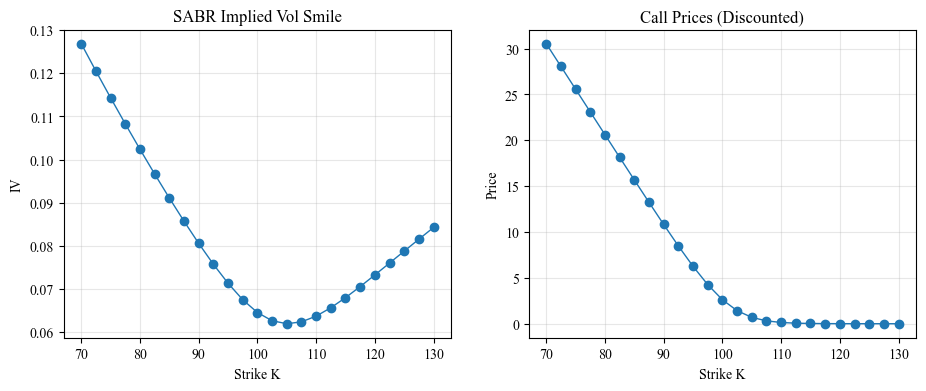

In [3]:
# Synthetic smile
S, r, q = 100.0, 0.01, 0.00
T       = 0.75
F       = S * np.exp((r - q) * T)

# "True" SABR params for the synthetic smile
alpha_t, beta_t, rho_t, nu_t = 0.25, 0.7, -0.25, 0.6

K_grid = np.linspace(70, 130, 25)
iv_grid = np.array([sabr_iv(F, K, T, alpha_t, beta_t, rho_t, nu_t) for K in K_grid])

# Price via forward BS (undiscounted) and discount
DF = np.exp(-r*T)
call_undisc = np.array([bs_call_forward(F, K, T, iv) for K,iv in zip(K_grid,iv_grid)])
call_prices = DF * call_undisc

fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(K_grid, iv_grid, marker="o", lw=1)
ax[0].set_title("SABR Implied Vol Smile")
ax[0].set_xlabel("Strike K"); ax[0].set_ylabel("IV")
ax[0].grid(True, alpha=0.3)

ax[1].plot(K_grid, call_prices, marker="o", lw=1)
ax[1].set_title("Call Prices (Discounted)")
ax[1].set_xlabel("Strike K"); ax[1].set_ylabel("Price")
ax[1].grid(True, alpha=0.3)
plt.show()


## 3) Round-trip check (Price → IV → Price)
Price with SABR, invert IV from BS, reprice via BS — they should match closely.


In [4]:
Ks = [80.0, 100.0, 120.0]
for K in Ks:
    price_sabr = sabr_price(S, K, T, r, q, alpha_t, beta_t, rho_t, nu_t, option="call")
    iv_rt = implied_vol_from_price(S, K, T, r, price_sabr, option_type="call", tol=1e-10)
    price_bs = black_scholes_price(S, K, T, r, iv_rt, option_type="call")
    print(f"K={K:.0f} | price_sabr={price_sabr:.8f}  price_bs={price_bs:.8f}  diff={abs(price_bs-price_sabr):.3e}")


K=80 | price_sabr=20.60926532  price_bs=20.60926532  diff=3.634e-12
K=100 | price_sabr=2.61512033  price_bs=2.61512033  diff=1.115e-13
K=120 | price_sabr=0.00610493  price_bs=0.00610493  diff=1.573e-11


## 4) Calibration in IV-space
Given synthetic IVs, recover (α, β, ρ, ν) via least squares on IVs.
We’ll try both **fixed β** and **free β**.


In [5]:
# IV-space calibration (fixed beta)
params_fixb, res_fixb = sabr_calibrate_iv(K_grid, np.full_like(K_grid, T), iv_grid, F, beta=beta_t, maxiter=400, disp=False)
print("IV-calibration (fixed beta)  =>", params_fixb)

# IV-space calibration (free beta)
params_freeb, res_freeb = sabr_calibrate_iv(K_grid, np.full_like(K_grid, T), iv_grid, F, beta=None, maxiter=400, disp=False)
print("IV-calibration (free beta)   =>", params_freeb)


IV-calibration (fixed beta)  => {'alpha': np.float64(0.24984335084961254), 'beta': 0.7, 'rho': np.float64(-0.24926191247166685), 'nu': np.float64(0.6009224911003309)}
IV-calibration (free beta)   => {'alpha': np.float64(0.17720301020191995), 'beta': np.float64(0.7742215083237036), 'rho': np.float64(-0.25963648051461385), 'nu': np.float64(0.6051354412346002)}


### Visual check: IV fit vs ground truth


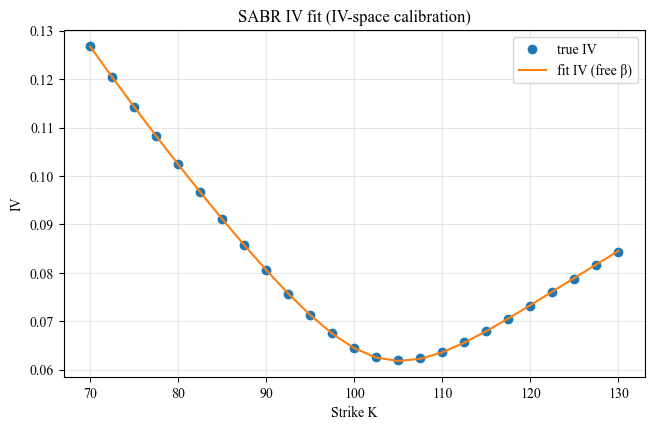

In [6]:
# Compare fitted IVs (free beta) to ground truth
iv_fit = np.array([sabr_iv(F, K, T, params_freeb["alpha"], params_freeb["beta"], params_freeb["rho"], params_freeb["nu"])
                   for K in K_grid])

plt.plot(K_grid, iv_grid, "o", label="true IV")
plt.plot(K_grid, iv_fit, "-", label="fit IV (free β)")
plt.title("SABR IV fit (IV-space calibration)")
plt.xlabel("Strike K"); plt.ylabel("IV"); plt.grid(True, alpha=0.3); plt.legend()
plt.show()


## 5) Calibration in price-space (with vega weights)
Price errors are sensitive to wings; a standard trick is to weight by **vega** (or simply emphasize ATM).
We’ll add mild noise and then fit back.


In [7]:
# Build synthetic noisy prices (calls across strikes)
rng = np.random.default_rng(7)
prices_true = np.array([sabr_price(S, K, T, r, q, alpha_t, beta_t, rho_t, nu_t, option="call") for K in K_grid])
prices_obs  = prices_true + rng.normal(0.0, 0.01, size=len(prices_true))

# Approx vega weights using the true IVs (proxy)
iv_true = np.array([sabr_iv(F, K, T, alpha_t, beta_t, rho_t, nu_t) for K in K_grid])

def bs_vega_spot(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*np.sqrt(T))
    return S * (1.0/np.sqrt(2*np.pi)) * np.exp(-0.5*d1*d1) * np.sqrt(T)

w_vega = np.array([bs_vega_spot(S, K, T, r, sig) for K, sig in zip(K_grid, iv_true)])
w_vega = w_vega / max(w_vega.max(), 1e-12)

sides = np.array(["call"] * len(K_grid))
params_price_fixb, res_price_fixb = sabr_calibrate_price(
    S, r, q, K_grid, np.full_like(K_grid, T),
    prices_obs, sides,
    w=w_vega, beta=beta_t, x0=np.array([alpha_t*0.9, rho_t*0.9, nu_t*0.9]),
    bounds=[(1e-6, 5.0), (-0.999, 0.999), (1e-6, 5.0)],
    maxiter=400, disp=False
)
params_price_fixb


{'alpha': np.float64(0.24988790407766714),
 'beta': 0.7,
 'rho': np.float64(-0.257543404148235),
 'nu': np.float64(0.6007592824107996)}

### Visual check: Price fit vs noisy observations


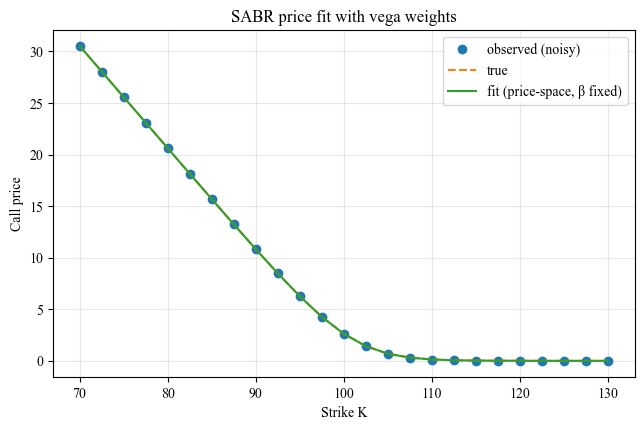

Mean abs price error vs true (fit): 0.0009446172897019414


In [8]:
alpha_f, beta_f, rho_f, nu_f = params_price_fixb["alpha"], params_price_fixb["beta"], params_price_fixb["rho"], params_price_fixb["nu"]
prices_fit = np.array([sabr_price(S, K, T, r, q, alpha_f, beta_f, rho_f, nu_f, option="call") for K in K_grid])

plt.plot(K_grid, prices_obs, "o", label="observed (noisy)")
plt.plot(K_grid, prices_true, "--", label="true")
plt.plot(K_grid, prices_fit, "-", label="fit (price-space, β fixed)")
plt.title("SABR price fit with vega weights")
plt.xlabel("Strike K"); plt.ylabel("Call price"); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

mae = np.mean(np.abs(prices_fit - prices_true))
print("Mean abs price error vs true (fit):", mae)


## 6) Diagnostics & sensitivity
Small nudges to ρ and ν to see qualitative effect on the smile.


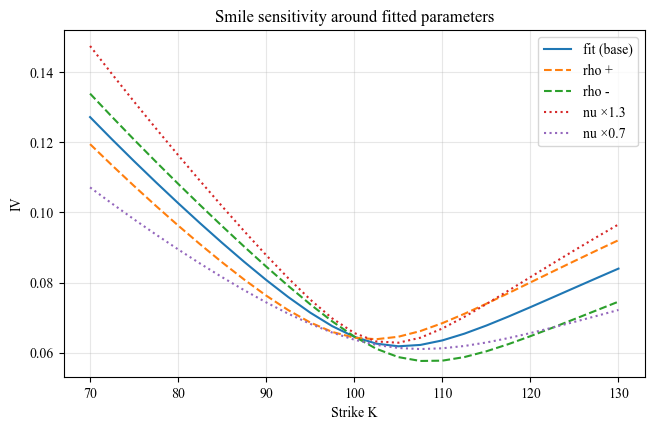

In [9]:
def smile(F, T, p):
    return np.array([sabr_iv(F, K, T, p["alpha"], p["beta"], p["rho"], p["nu"]) for K in K_grid])

p_base = dict(alpha=alpha_f, beta=beta_f, rho=rho_f, nu=nu_f)

p_rho_up = dict(**p_base); p_rho_up["rho"] = min(0.99, p_base["rho"] + 0.2)
p_rho_dn = dict(**p_base); p_rho_dn["rho"] = max(-0.99, p_base["rho"] - 0.2)
p_nu_up  = dict(**p_base); p_nu_up["nu"]  = p_base["nu"] * 1.3
p_nu_dn  = dict(**p_base); p_nu_dn["nu"]  = max(1e-6, p_base["nu"] * 0.7)

plt.plot(K_grid, smile(F,T,p_base),   "-",  label="fit (base)")
plt.plot(K_grid, smile(F,T,p_rho_up), "--", label="rho +")
plt.plot(K_grid, smile(F,T,p_rho_dn), "--", label="rho -")
plt.plot(K_grid, smile(F,T,p_nu_up),  ":",  label="nu ×1.3")
plt.plot(K_grid, smile(F,T,p_nu_dn),  ":",  label="nu ×0.7")
plt.title("Smile sensitivity around fitted parameters")
plt.xlabel("Strike K"); plt.ylabel("IV"); plt.grid(True, alpha=0.3); plt.legend()
plt.show()


## 7) (Optional) Real-market calibration via your `data_loader`
Set `USE_MARKET=True` to try on a live ticker:
- fetch latest price & chain
- pick an expiry near 1–2 months out
- fit SABR in IV-space (β fixed or free)

> Note: Requires network and `yfinance` to be available.


[*********************100%***********************]  1 of 1 completed
C:\Users\datog\AppData\Local\Temp\ipykernel_21148\3177821551.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_mkt  = float(stock["Close"].iloc[-1])


Market SABR fit (β fixed): {'alpha': np.float64(1.0095472022780845), 'beta': 0.7, 'rho': np.float64(-0.5762101536926864), 'nu': np.float64(5.0)}


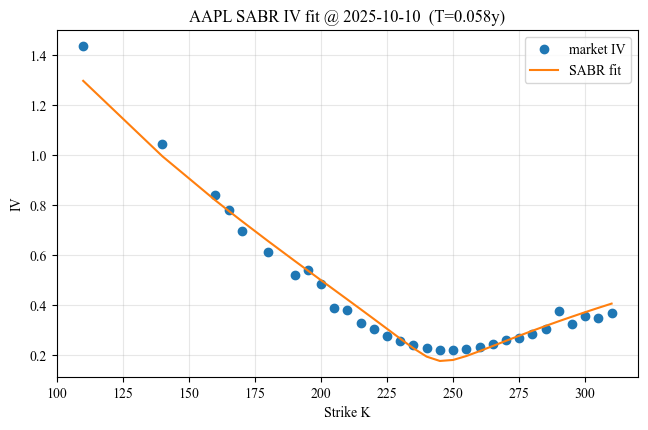

In [12]:
USE_MARKET = True  # set True to try live calibration

if USE_MARKET:
    from data.data_loader import fetch_stock_data, compute_annualized_volatility, fetch_current_chain

    def as_utc(ts):
        ts = pd.to_datetime(ts)
        return ts.tz_localize("UTC") if ts.tzinfo is None else ts.tz_convert("UTC")

    TICKER = "AAPL"
    stock = fetch_stock_data(TICKER, start="2023-01-01")
    S_mkt  = float(stock["Close"].iloc[-1])
    r_mkt, q_mkt = 0.02, 0.00  # quick placeholders

    chain = fetch_current_chain(TICKER)  # columns: expiration, strike, type, mid
    chain = chain.dropna()

    # Normalize all expirations to UTC-aware
    chain["expiration"] = chain["expiration"].apply(as_utc)

    # Pick an expiry ~30–60 days out from *now* (UTC-aware)
    now_utc = as_utc(pd.Timestamp.utcnow())
    future = chain.loc[(chain["expiration"] - now_utc).dt.days > 10].copy()
    if future.empty:
        print("No suitable future expiries (>10 days) available.")
    else:
        # Sort by time-to-expiry and pick the 2nd nearest (≈30–60d), fallback to nearest
        future["ttd_days"] = (future["expiration"] - now_utc).dt.days
        future = future.sort_values("ttd_days")
        unique_exps = future["expiration"].drop_duplicates().to_list()
        exp = unique_exps[min(1, len(unique_exps) - 1)]  # 2nd nearest if exists

        sl = chain[chain["expiration"] == exp].copy()

        # Time to maturity in years (UTC-consistent)
        T_mkt = max(1e-6, (exp - now_utc).total_seconds() / (365.25 * 24 * 3600))

        # Build calls only for a simple smile around ATM
        from src.black_scholes import implied_vol_from_price  # ensure in scope
        from src.sabr import sabr_iv, sabr_calibrate_iv

        S0 = S_mkt
        F_mkt = S0 * np.exp((r_mkt - q_mkt) * T_mkt)

        calls = sl[sl["type"].str.lower() == "call"].copy()
        calls = calls.replace([np.inf, -np.inf], np.nan).dropna(subset=["strike", "mid"])

        if calls.empty:
            print("No call quotes at selected expiry.")
        else:
            calls["iv"] = [
                implied_vol_from_price(S0, float(K), T_mkt, r_mkt, float(price), option_type="call")
                for K, price in zip(calls["strike"].astype(float), calls["mid"].astype(float))
            ]
            calls = calls.replace([np.inf, -np.inf], np.nan).dropna(subset=["iv"])

            if calls.empty:
                print("Could not compute IVs for selected expiry.")
            else:
                K_m = calls["strike"].values.astype(float)
                IV_m = calls["iv"].values.astype(float)

                params_mkt, res_mkt = sabr_calibrate_iv(
                    K_m, np.full_like(K_m, T_mkt), IV_m, F_mkt,
                    beta=0.7, maxiter=400, disp=False
                )
                print("Market SABR fit (β fixed):", params_mkt)

                # Plot fitted smile
                iv_fit_mkt = np.array([
                    sabr_iv(F_mkt, K, T_mkt,
                            params_mkt["alpha"], params_mkt["beta"],
                            params_mkt["rho"], params_mkt["nu"])
                    for K in K_m
                ])

                plt.plot(K_m, IV_m, "o", label="market IV")
                plt.plot(K_m, iv_fit_mkt, "-", label="SABR fit")
                plt.title(f"{TICKER} SABR IV fit @ {exp.date()}  (T={T_mkt:.3f}y)")
                plt.xlabel("Strike K"); plt.ylabel("IV"); plt.grid(True, alpha=0.3); plt.legend()
                plt.show()
